In [5]:
# basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import kruskal, ttest_ind
import scikit_posthocs as sp
from statannot import add_stat_annotation
import warnings

# ignore warnings to keep output clean
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')

# %matplotlib inline (not needed in scripts, fine in notebooks)

# configure matplotlib fonts for illustrator editing
plt.rcParams.update({
    'pdf.fonttype': 42,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
})


# Load data

In [6]:
data_dir = '/Users/hannalemmik/Dropbox/C3ar1_longitudinal_MRI_paper_2025/data/'

cohort2 = pd.read_excel(os.path.join(data_dir, 'volROI_Cohort2.xlsx'))
cohort1_30 = pd.read_excel(os.path.join(data_dir, 'volROI_Cohort1_PND30.xlsx'))
cohort1_90 = pd.read_excel(os.path.join(data_dir, 'volROI_Cohort1_PND90.xlsx'))
cohort1_exvivo = pd.read_excel(os.path.join(data_dir, 'volROI_Cohort1_exvivo.xlsx'))

# tidy
cohort1_90 = cohort1_90.drop(columns=['group'])



In [7]:
# melt dataframes and pivot back to make sure subject columns are in the right order
def melt_and_pivot(df):
    melted = pd.melt(df, id_vars=['subject', 'Genotype', 'Sex'], var_name='ROI_name', value_name='rel_vol')
    reshaped = melted.pivot_table(index=['subject', 'Genotype', 'Sex'], columns='ROI_name', values='rel_vol').reset_index()
    return reshaped

cohort1_30 = melt_and_pivot(cohort1_30)
cohort1_90 = melt_and_pivot(cohort1_90)
cohort1_exvivo = melt_and_pivot(cohort1_exvivo)
cohort2 = melt_and_pivot(cohort2)


In [8]:
value_counts = cohort1_90[['Genotype', 'Sex']].value_counts()
value_counts

Genotype  Sex
KO        M      18
WT        F      18
          M      17
KO        F      16
Name: count, dtype: int64

In [9]:
value_counts = cohort1_exvivo[['Genotype', 'Sex']].value_counts()
value_counts

Genotype  Sex
KO        M      17
WT        F      17
          M      17
KO        F      16
Name: count, dtype: int64

In [10]:
value_counts = cohort2[['Genotype', 'Sex']].value_counts()
value_counts

Genotype  Sex
WT        M      11
KO        M      10
          F       8
WT        F       8
Name: count, dtype: int64

## Calculate coefficients of variations

In [11]:


cmap2= ['#c0bec2','#915e95' ]

In [12]:
# for each pair of groups, calculate coefficient of variation (cv)
def compute_cv_table(df, genotype, label):
    sub = df[df['Genotype'] == genotype]
    data = sub.drop(['subject', 'Genotype', 'Sex'], axis=1).to_numpy()
    stds = np.nanstd(data, axis=0)
    means = np.nanmean(data, axis=0)
    cv = stds / means
    return pd.DataFrame({
        'ROI_name': sub.drop(['subject', 'Genotype', 'Sex'], axis=1).columns,
        'cv': cv,
        'Group': label
    })
# build summary tables for plotting and statistics
wt_30_cv = compute_cv_table(cohort1_30, 'WT', 'WT_30')
hom_30_cv = compute_cv_table(cohort1_30, 'KO', 'HOM_30')
df_30 = pd.concat([wt_30_cv, hom_30_cv], ignore_index=True)

wt_90_cv = compute_cv_table(cohort1_90, 'WT', 'WT_90')
hom_90_cv = compute_cv_table(cohort1_90, 'KO', 'HOM_90')
df_90 = pd.concat([wt_90_cv, hom_90_cv], ignore_index=True)

wt_exvivo_cv = compute_cv_table(cohort1_exvivo, 'WT', 'WT_exvivo')
hom_exvivo_cv = compute_cv_table(cohort1_exvivo, 'KO', 'HOM_exvivo')
df_exvivo = pd.concat([wt_exvivo_cv, hom_exvivo_cv], ignore_index=True)


In [13]:
df_30['ROI_name'].unique()

array(['amygdala', 'arbor_vitae', 'auditory_cortex', 'bed_nuclei',
       'cerebellar_cortex', 'cerebellar_nuclei',
       'cerebellar_white_matter', 'cerebral_aqueduct', 'choroid_plexus',
       'cingulate_cortex', 'claustrum', 'corpus_callosum',
       'cortical_subplate', 'diagonal_band', 'dorsal_peduncular_area',
       'entorhinal_cortex', 'fiber_tracts', 'fimbria_fornix', 'flocculus',
       'fourth_ventricle', 'frontal_cortex',
       'gustatory_and_visceral_cortex', 'habenula', 'hippocampus_dorsal',
       'hippocampus_ventral', 'hypothalamus', 'inferior_colliculus',
       'infralimbic_cortex', 'insular_cortex', 'internal_capsule',
       'lateral_geniculate', 'lateral_ventricle', 'medial_geniculate',
       'medulla', 'midbrain', 'midbrain_white_matter', 'motor_cortex',
       'nodulus', 'nucleus_accumbens', 'nucleus_of_posterior_commussure',
       'olfactory_cortex', 'olfactory_tracts', 'optic_tract',
       'orbital_cortex', 'pallidum', 'parietal_cortex',
       'pedunculo

In [14]:
# remove csf regions from all dataframes
csf_regions = [
    'cerebral_aqueduct', 'choroid_plexus', 'fourth_ventricle',
    'lateral_ventricle', 'periaqueductal_gray', 'third_ventricle'
]
df_30 = df_30[~df_30['ROI_name'].isin(csf_regions)]
df_90 = df_90[~df_90['ROI_name'].isin(csf_regions)]
df_exvivo = df_exvivo[~df_exvivo['ROI_name'].isin(csf_regions)]

In [17]:
df_30['ROI_name'].unique()

array(['amygdala', 'arbor_vitae', 'auditory_cortex', 'bed_nuclei',
       'cerebellar_cortex', 'cerebellar_nuclei',
       'cerebellar_white_matter', 'cingulate_cortex', 'claustrum',
       'corpus_callosum', 'cortical_subplate', 'diagonal_band',
       'dorsal_peduncular_area', 'entorhinal_cortex', 'fiber_tracts',
       'fimbria_fornix', 'flocculus', 'frontal_cortex',
       'gustatory_and_visceral_cortex', 'habenula', 'hippocampus_dorsal',
       'hippocampus_ventral', 'hypothalamus', 'inferior_colliculus',
       'infralimbic_cortex', 'insular_cortex', 'internal_capsule',
       'lateral_geniculate', 'medial_geniculate', 'medulla', 'midbrain',
       'midbrain_white_matter', 'motor_cortex', 'nodulus',
       'nucleus_accumbens', 'nucleus_of_posterior_commussure',
       'olfactory_cortex', 'olfactory_tracts', 'optic_tract',
       'orbital_cortex', 'pallidum', 'parietal_cortex',
       'pedunculopontine_nucleus', 'perirhinal_cortex', 'piriform_cortex',
       'pons', 'postrhinal_co

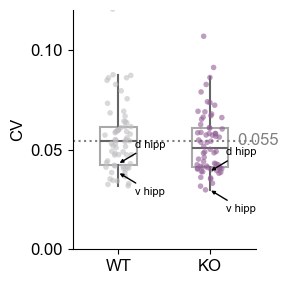

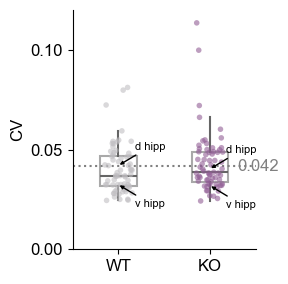

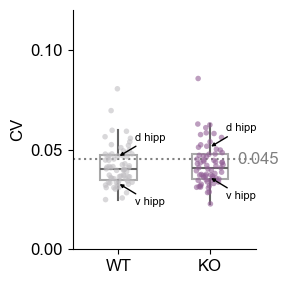

In [15]:
def plot_cv_box(df, order, group_labels, save_path):
    plt.figure(figsize=(3, 3))
    ax = sns.boxplot(
        data=df,
        showfliers=False,
        showcaps=False,
        x="Group",
        y="cv",
        order=order,
        palette=['darkgray', 'darkgray'],
        boxprops={'facecolor': 'none', 'edgecolor': 'darkgray'},
        width=0.4
    )
    sns.stripplot(
        data=df,
        x="Group",
        y="cv",
        order=order,
        palette=cmap2,
        size=4,
        alpha=0.6,jitter=0.15,
        ax=ax
    )
    # annotate mean line
    overall_mean = df['cv'].mean()
    plt.axhline(y=overall_mean, color='gray', linestyle=':')
    plt.text(1.3, overall_mean, f'{overall_mean:.3f}', verticalalignment='center', color='gray')
    plt.xticks(ticks=[0, 1], labels=group_labels)
    ax.set(ylabel='CV')
    plt.ylim([0, 0.12])
    ax.yaxis.set_ticks(np.arange(0, 0.12, 0.05))
    sns.despine()
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

# define a generic hippocampus labeling function
def label_hippocampus(df, group, ax, x_offset=0.18, y_offset=0.007):
    group_data = df[df['Group'] == group]
    dorsal = group_data[group_data['ROI_name'].str.contains('hippocampus_dorsal', case=False)]
    ventral = group_data[group_data['ROI_name'].str.contains('hippocampus_ventral', case=False)]
    x = 0 if group.startswith('WT') else 1
    # annotate d hipp
    for i, (_, row) in enumerate(dorsal.iterrows()):
        ax.annotate('d hipp', xy=(x, row['cv']),
            xytext=(x + x_offset, row['cv'] + (i + 1) * y_offset),
            textcoords='data', ha='left', va='bottom', fontsize=8,
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, shrinkA=1, shrinkB=1, mutation_scale=5))
        # annotate v hipp
    for i, (_, row) in enumerate(ventral.iterrows()):
        ax.annotate('v hipp', xy=(x, row['cv']),
            xytext=(x + x_offset, row['cv'] - (i + 1) * y_offset),
            textcoords='data', ha='left', va='top', fontsize=8,
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, shrinkA=1, shrinkB=1, mutation_scale=5))

# plot and annotate each cohort
for df, order, save_path in [
    (df_30, ['WT_30', 'HOM_30'], '/Users/hannalemmik/Dropbox/KO_paper/volume/cv_PND30.pdf'),
    (df_90, ['WT_90', 'HOM_90'], '/Users/hannalemmik/Dropbox/KO_paper/volume/cv_PND90.pdf'),
    (df_exvivo, ['WT_exvivo', 'HOM_exvivo'], '/Users/hannalemmik/Dropbox/KO_paper/volume/cv_exvivo.pdf')
]:
    plt.figure(figsize=(3, 3))
    ax = sns.boxplot(
        data=df, showfliers=False, showcaps=False, x="Group", y="cv",
        order=order, palette=['darkgray', 'darkgray'],
        boxprops={'facecolor': 'none', 'edgecolor': 'darkgray'}, width=0.4
    )
    sns.stripplot(
        data=df, x="Group", y="cv", order=order, palette=cmap2,
        size=4, alpha=0.6, jitter=0.15, ax=ax
    )
    overall_mean = df['cv'].mean()
    plt.axhline(y=overall_mean, color='gray', linestyle=':')
    plt.text(1.3, overall_mean, f'{overall_mean:.3f}', verticalalignment='center', color='gray')
    plt.xticks(ticks=[0, 1], labels=['WT', 'KO'])
    ax.set(ylabel='CV')
    plt.ylim([0, 0.12])
    ax.yaxis.set_ticks(np.arange(0, 0.12, 0.05))
    sns.despine()
    plt.xlabel('')
    # label hippocampus points for both groups
    label_hippocampus(df, order[0], ax)
    label_hippocampus(df, order[1], ax)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)

## Quick stats

In [16]:

for df, name in zip([df_30, df_90, df_exvivo], ['df_30', 'df_90', 'df_exvivo']):
    print(f"Running stats for {name}...")
    groups = df['Group'].unique()
    grouped_data = [df['cv'][df['Group'] == group] for group in groups]
    kruskal_result = kruskal(*grouped_data)
    print("kruskal-wallis p-value:", kruskal_result.pvalue)
    if kruskal_result.pvalue < 0.05:
        result = sp.posthoc_dunn(df, val_col='cv', group_col='Group', p_adjust='bonferroni')
        print(result)
    else:
        print("No significant effect, skipping dunn’s test.\n")


Running stats for df_30...
kruskal-wallis p-value: 0.4152696352461094
No significant effect, skipping dunn’s test.

Running stats for df_90...
kruskal-wallis p-value: 0.169303137793265
No significant effect, skipping dunn’s test.

Running stats for df_exvivo...
kruskal-wallis p-value: 0.67410980236455
No significant effect, skipping dunn’s test.

